In [1]:
from sklearn.datasets import load_files
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn import svm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline
#import mglearn
import os
import warnings
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
#for i in range(250,255):
#    print(i) 
i=0    
ret_10D = 1
for j in range(i, i+10):
    ret_10D *= (1+0.01)
ret_10D -= 1
print(ret_10D)

0.10462212541120453


In [2]:
pr_dir = '/Users/zissis/Desktop/press_releases/'
pr_df = pd.read_parquet(pr_dir + 'PR_panel.parquet')
#pr_df = pd.read_parquet(pr_dir + 'PR_panel_stem_unstem_pred.parquet')

In [18]:
pr_df['text'].iloc[2][:100]

'ex  vex unassociated document aep industries inc reports fiscal  third quarter year date results sou'

In [15]:
#pr_final.head(10)
#rms = mean_squared_error(pr_final['stemmed-pred'].values,pr_final.LRet_12pm_OpenNext)
#pr_final['stemmed-pred'].values
#plt.hist(pr_final.LRet_12pm_OpenNext, bins=100, histtype='step');
#plt.hist(pr_final['clean-pred'], density=True, bins=30)

array([array([0.00021207], dtype=float32),
       array([0.00047557], dtype=float32),
       array([0.00046675], dtype=float32), ...,
       array([0.00040304], dtype=float32),
       array([0.00015319], dtype=float32),
       array([0.0002128], dtype=float32)], dtype=object)

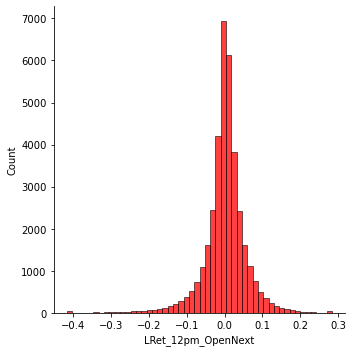

In [12]:
sns.displot(pr_df['LRet_12pm_OpenNext'], kde=False, color='red', bins=50)

In [19]:
word_limit  = 200
def limit_words(text):
    return ' '.join(text.split(' ')[:word_limit])

text_train = pr_df.text_clean_stemmed.apply(limit_words)

print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))

type of text_train: <class 'pandas.core.series.Series'>
length of text_train: 36750


In [25]:
text_train.iloc[100]

'ex news releas contact media investor relat robert c ferri elena doom honeywel report full year sale billion proforma earn per share report earn per share morri township nj januari honeywel nyse hon today announc fourth quarter full year result follow sale billion versu billion organ growth reflect continu strength end market contribut new product launch geograph expans proforma earn exclud impact pension mark market adjust per share report earn reflect loss per share versu earn per share prior year pension mark market adjust per share calcul use million weight averag share outstand assum dilut cash flow oper billion includ million cash pension contribut quarter free cash flow cash flow oper less capit expenditur billion prior million cash pension contribut compani report full year result includ sale billion approxim organ sale growth reflect strong end market success new product launch continu expans high growth region proforma earn exclud impact pension mark market adjust per share 

In [50]:
y_train = pr_df.LRet_12pm_OpenNext



N = len(text_train)

max_df = np.int64(np.floor(0.3 * N))
min_df = np.int64(np.floor(0.001 * N))


#%% Vectorize dataset


#vect = CountVectorizer(min_df=20, stop_words="english", max_df=350).fit(text_train)
vect = TfidfVectorizer(min_df=min_df, max_df=max_df).fit(text_train)

X_train = vect.transform(text_train)
#print("X_train with stop words:\n{}".format(repr(X_train)))


feature_names = vect.get_feature_names()
#print("Number of features: {}".format(len(feature_names)))
#print("First 20 features:\n{}".format(feature_names[:20]))
#print("Features 1010 to 1030:\n{}".format(feature_names[1010:10030]))
#print("Every 200th feature:\n{}".format(feature_names[::200]))

X_train_binary = 1.0 * (X_train > 0)

#%% ElasticNet estimation


regr = ElasticNetCV(cv=5)
regr.fit(X_train, y_train)


y_fitted = regr.predict(X_train)


pr_df['EN_fit'] = y_fitted

#%% Support Vector Regression1`

SVM_regr = svm.SVR()
SVM_regr.fit(X_train, y_train)
SVM_y_fitted = SVM_regr.predict(X_train)

pr_df['SVM_fit'] = SVM_y_fitted


#%% Random Forest Regression

#RF_regr = RandomForestRegressor(max_depth=2, random_state=0, verbose=1)
#RF_regr.fit(X_train, y_train)
#RF_y_fitted = RF_regr.predict(X_train)

#pr_df['RF_fit'] = RF_y_fitted


pr_df.to_parquet('PR_panel_EN_fit.parquet')

In [63]:
from sklearn.metrics import r2_score
pr_df[['EN_fit','SVM_fit','stemmed-pred']]
#rms = mean_squared_error(pr_df.SVM_fit,pr_df.LRet_12pm_OpenNext)
#rms
r2_score(pr_df['stemmed-pred'],pr_df.LRet_12pm_OpenNext)

-96673.50238253547

/Users/zissis/anaconda3/envs/tensor/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

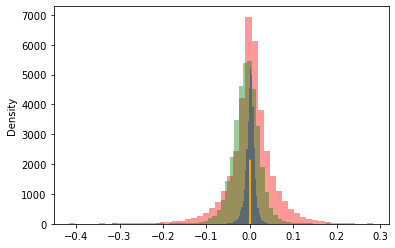

In [59]:
sns.distplot(pr_df[['LRet_12pm_OpenNext']], kde=False, color='red', bins=50)
sns.distplot(pr_df[['EN_fit']], kde=False, color='blue', bins=50)
sns.distplot(pr_df[['SVM_fit']], kde=False, color='green', bins=50)
sns.distplot(pr_df[['stemmed-pred']], kde=True, color='orange', bins=50)

In [71]:
df = pd.DataFrame([vect.get_feature_names(), regr.coef_]).T
df.columns = ['word', 'coef']
df['coef'] = np.float64(df['coef'])

df = df.sort_values(['coef'])

In [72]:
df.head(20)

,word,coef
926,disappoint,-0.193340
1556,howev,-0.105632
548,challeng,-0.079786
2848,revis,-0.077399
704,confid,-0.062379
1917,lower,-0.062097
870,delay,-0.055345
851,declin,-0.051711
853,decreas,-0.044734
3299,term,-0.041035


In [60]:
dense = np.squeeze(np.asarray(SVM_regr.coef_.todense()))
dense.shape
#flat = dense.flatten()
#new = np.squeeze(flat)

(3671,)

In [73]:
dff = pd.DataFrame([vect.get_feature_names(), np.squeeze(np.asarray(SVM_regr.coef_.todense()))]).T
dff.columns = ['word', 'coef']
dff['coef'] = np.float64(dff['coef'])

dff = dff.sort_values(['coef'])

In [74]:
dff.head(20)

,word,coef
926,disappoint,-0.271842
2842,retroact,-0.262894
80,agenda,-0.255656
2275,notwithstand,-0.239770
651,colo,-0.235221
1642,inspect,-0.234252
1556,howev,-0.232668
1719,jet,-0.218272
3063,slide,-0.216781
2601,prolong,-0.216482
